# **Reporte de Solución del Reto**

**Equipo Blue Leg**

Diego Sú Gómez - A01620476

Vanessa Méndez Palacios - A01639925

Estefanía Pérez Yeo - A01639270

Francisco Javier Sanchez Panduro - A01639832

## **Importación de las librerías**
---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, SequentialFeatureSelector, RFE
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score

## **Manipulación y concatenación de los datos**
---

Al observar que se tenían 15 archivos .csv pertenecientes a cada uno de los pacientes, se decidió que la mejor manera de cargar la información sería concatenar todos los archivos .csv en un DataFrame y posteriormente descargarlo en formato .csv y únicamente cargar ese archivo al momento, para evitar tener que hacer la concatenación manual cada vez que se requiera hacer uso de los datos.

In [ ]:
# Código de un solo uso - Leer los archivos .csv de cada paciente y concatenarlos en un DataFrame que será descargado

#Leer los dataframes y añadir una columna con el id del paciente para poder combinarlos
'''archivos_csv = glob.glob('/content/*.csv')

df_global = pd.DataFrame()
num_paciente = 1'''

#Leer cada uno de los .csv, añadir la columna patient_id y señalar los registros con el número de paciente correspondiente
'''for archivo in archivos_csv:
    df_paciente = pd.read_csv(archivo)
    df_paciente.insert(0,"patient_id",num_paciente)
    df_global = pd.concat([df_global, df_paciente])
    num_paciente +=1'''


'for archivo in archivos_csv:\n    df_paciente = pd.read_csv(archivo)\n    df_paciente.insert(0,"patient_id",num_paciente)\n    df_global = pd.concat([df_global, df_paciente])\n    num_paciente +=1'

Tras ejecutar este bloque de código, el Dataframe ya cuenta con todos los registros de los pacientes y con un ID que identifica cada registro con el paciente correspondiente. Ahora lo siguiente será descargar ese mismo DataFrame en formato .csv para no tener que ejecutar este código cada vez que se ejecute este archivo o cuando se requiera la información.

In [ ]:
#Descargar el archivo en formato .csv

# df_global.to_csv("patients_data.csv")

## **Carga de datos**
---

Tras haber descargado el archivo con todos los datos de los pacientes, lo único necesario para poder leer los datos de todos los pacientes es cargar el archivo en el entorno y leerlo.

In [ ]:
#Leer el archivo con los datos de los pacientes
df = pd.read_csv("patients_data.csv")

## **Limpieza y Exploración de los datos**
---

Tras cargar el archivo, lo siguiente es ver cómo se encuentra la distribución de los datos, lo que se puede realizar fácilmente con un .head()

In [ ]:
df.head()

,Unnamed: 0,patient_id,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,0,1,2021-04-15 14:27:16.180,-0.737061,-0.053955,-0.434326,-0.943604,0.105469,-0.126465,6
1,1,1,2021-04-15 14:27:16.200,-0.791260,-0.100342,-0.452148,-0.983398,0.139893,-0.096924,6
2,2,1,2021-04-15 14:27:16.219,-0.867432,-0.069824,-0.468018,-0.998047,0.141113,-0.178955,6
3,3,1,2021-04-15 14:27:16.239,-0.933350,0.050293,-0.456299,-1.005859,0.177002,-0.220703,6
4,4,1,2021-04-15 14:27:16.260,-0.911621,0.123291,-0.488525,-0.957520,0.094727,-0.208008,6


Primeramente, se puede observar que, al concatenar los datos en un sólo dataframe, se creó una columna extra la cual no es útil, por lo que se debe borrar antes de proseguir con la exploración.

In [ ]:
#Borrar la columna sin nombre
df = df.drop(["Unnamed: 0"],axis=1)

Ya con la columna innecesaria eliminada, lo siguiente por hacer es analizar el conjunto en sí mismo, para entender cómo está estructurado y poder comenzar a tener una percepción de los datos.

In [ ]:
#Encontrar las dimensiones del DataFrame
df.shape

(1832560, 9)

In [ ]:
#Observar los tipos de datos que tiene el DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1832560 entries, 0 to 1832559
Data columns (total 9 columns):
 #   Column      Dtype  
---  ------      -----  
 0   patient_id  int64  
 1   timestamp   object 
 2   back_x      float64
 3   back_y      float64
 4   back_z      float64
 5   thigh_x     float64
 6   thigh_y     float64
 7   thigh_z     float64
 8   label       int64  
dtypes: float64(6), int64(2), object(1)
memory usage: 125.8+ MB


In [ ]:
#Observar la cantidad de fechas únicas
df["timestamp"].unique().size

1832560

In [ ]:
#Observar la cantidad de "labels" únicos
df["label"].unique()

array([6, 3, 1, 5, 7, 8, 4])

Primeramente, se puede observar que el DataFrame con el que se trabajará cuenta con 1,832,560 observaciones y 9 variables. Además, casi todas las variables disponibles en el DataFrame son numéricas, exceptuando el timestamp. Se tiene el conocimiento de que cada observación (fila del DataFrame) corresponde a una medición de los sensores de cada paciente. Por cada observación se tiene el ID del paciente, una marca de tiempo única que indica cuándo se tomó dicha medición, y cada uno de los valores del acelerómetro de cada sensor, uno por cada eje. Finalmente, también se encuentra el label, que corresponde al tipo de actividad que se estaba realizando según las medidas de los sensores. Se observa que hay 7 tipos de actividades diferentes, a las cuales corresponde un número.

Antes de proseguir con el análisis de las variables y observaciones, sería prudente asegurar que el DataSet no contenga valores nulos o duplicados.

In [ ]:
#Encontrar el total de valores nulos en cada columna
pd.isna(df).sum()

patient_id    0
timestamp     0
back_x        0
back_y        0
back_z        0
thigh_x       0
thigh_y       0
thigh_z       0
label         0
dtype: int64

In [ ]:
#Encontrar los valores duplicados en el DataFrame
df[df.duplicated()]

,patient_id,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label


Tras ejecutar estas dos líneas de código, se puede observar que en el DataFrame no hay valores nulos ni duplicados, por lo que no hay necesidad de eliminar o modificar observaciones dentro del conjunto de información.

Realizando un análisis más a fondo del dataset, en el DataFrame se observa que "label" es una variable numérica. Sin embargo, corresponde a un tipo de actividad, por lo que sería útil poner una columna que indique el nombre al que se refiere el label, para evitar tener que buscarlo en el diccionario cuando se necesite, y si se llegase a realizar un modelo, se puede remover o declarar otra variable para hacerlo.

De acuerdo con el sitio donde se obtuvo el Dataset, se sabe que cada número corresponde a una actividad, y se relacionan de la siguiente forma:

* 1: walking
* 3: shuffling
* 4: stairs (ascending)
* 5: stairs (descending)
* 6: standing
* 7: sitting
* 8: lying

Con este conocimiento, se puede agregar la columna al DataFrame.

In [ ]:
#Añadir la columna del nombre de la actividad que corresponde a cada Label para facilitar el entendimiento de los datos
df["activity_type"] = np.select([df["label"]==1,df["label"]==3,df["label"]==4,df["label"]==5,df["label"]==6,df["label"]==7,df["label"]==8],["walking", "shuffling","stairs (up)", "stairs (down)", "standing", "sitting", "lying"])
df.head()

,patient_id,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label,activity_type
0,1,2021-04-15 14:27:16.180,-0.737061,-0.053955,-0.434326,-0.943604,0.105469,-0.126465,6,standing
1,1,2021-04-15 14:27:16.200,-0.791260,-0.100342,-0.452148,-0.983398,0.139893,-0.096924,6,standing
2,1,2021-04-15 14:27:16.219,-0.867432,-0.069824,-0.468018,-0.998047,0.141113,-0.178955,6,standing
3,1,2021-04-15 14:27:16.239,-0.933350,0.050293,-0.456299,-1.005859,0.177002,-0.220703,6,standing
4,1,2021-04-15 14:27:16.260,-0.911621,0.123291,-0.488525,-0.957520,0.094727,-0.208008,6,standing


## **Análisis y Visualización de los datos**
---

Después de haber asegurado que los datos no tuvieran duplicados ni valores vacíos, y tras ya tener todos los datos del Dataset disponibles en el DataFrame, se puede empezar a analizar el mismo, para encontrar relaciones entre los datos, su significancia y otros parámetros que sean útiles para conocer la información con la que se va a trabajar.

Lo primero que se puede realizar es utilizar el método **describe** de Pandas para encontrar información acerca de los datos en el DataFrame, como su dispersión, tendencias e información estadística básica de los datos.

In [ ]:
#Obtener información general del DataFrame
df.describe()

,patient_id,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
count,1.832560e+06,1.832560e+06,1.832560e+06,1.832560e+06,1.832560e+06,1.832560e+06,1.832560e+06,1.832560e+06
mean,8.121649e+00,-8.683814e-01,-3.178814e-02,2.244210e-02,-6.763959e-01,8.185066e-03,-3.858819e-01,3.940692e+00
std,4.196053e+00,2.756643e-01,1.556768e-01,4.279549e-01,5.596829e-01,2.707317e-01,5.087015e-01,2.912512e+00
min,1.000000e+00,-4.333252e+00,-2.031006e+00,-2.204834e+00,-7.942139e+00,-5.142578e+00,-7.593750e+00,1.000000e+00
25%,5.000000e+00,-9.909670e-01,-1.093750e-01,-2.692870e-01,-9.855960e-01,-1.132810e-01,-9.770510e-01,1.000000e+00
50%,8.000000e+00,-9.377440e-01,-1.855500e-02,-9.399400e-02,-9.357910e-01,-1.464800e-02,-1.906740e-01,3.000000e+00
75%,1.200000e+01,-8.344730e-01,5.761700e-02,3.078610e-01,-7.763700e-02,1.230470e-01,-3.174000e-03,7.000000e+00
max,1.500000e+01,3.630370e-01,1.576660e+00,1.179199e+00,3.395264e+00,5.725098e+00,3.953369e+00,8.000000e+00


Como se puede observar, el resultado de ejecutar esta línea de código es un resumen estadísitico de cada una de las variables numéricas que se encuentran dentro del DataFrame. Se puede ver el total de valores, la media, la desviación estándar, el valor mínimo y máximo y los cuartiles de cada una de las variables. Sin embargo, estas están expresadas en exponenciales debido a la configuración del método, y a la estructura de los datos del conjunto, por lo que para poder obtener correctamente el resumen de los 5 números, lo mejor sería calcularlos de forma separada y luego hacer la interpretación.

In [ ]:
#Encontrar los valores extremos de cada variable
df.min(numeric_only=True)

patient_id    1.000000
back_x       -4.333252
back_y       -2.031006
back_z       -2.204834
thigh_x      -7.942139
thigh_y      -5.142578
thigh_z      -7.593750
label         1.000000
dtype: float64

In [ ]:
df.max(numeric_only=True)

patient_id    15.000000
back_x         0.363037
back_y         1.576660
back_z         1.179199
thigh_x        3.395264
thigh_y        5.725098
thigh_z        3.953369
label          8.000000
dtype: float64

In [ ]:
#Encontrar la mediana de cada variable
df.median(numeric_only=True)

patient_id    8.000000
back_x       -0.937744
back_y       -0.018555
back_z       -0.093994
thigh_x      -0.935791
thigh_y      -0.014648
thigh_z      -0.190674
label         3.000000
dtype: float64

In [ ]:
#Encontrar los cuartiles de cada variable
df.quantile([0.25,0.5,0.75],numeric_only=True)

,patient_id,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0.25,5.0,-0.990967,-0.109375,-0.269287,-0.985596,-0.113281,-0.977051,1.0
0.50,8.0,-0.937744,-0.018555,-0.093994,-0.935791,-0.014648,-0.190674,3.0
0.75,12.0,-0.834473,0.057617,0.307861,-0.077637,0.123047,-0.003174,7.0


Tras haber obtenido los 5 valores, se puede observar que las medidas de los acelerómetros suelen estar entre valores de -2 y 2, con algunas excepciones puntuales. Se puede ver que los valores más pequeños de la aceleración en los sensores son de -2, -4, -5 y -7, mientras que los valores máximos son de 1, 3 y 5. Otra cosa que se puede obtener de estos parámetros es que la mayoría de las mediciones de los acelerómetros son negativas. Esto se obtiene de los cuartiles de los datos, y se observa que la gran mayoría de ellos son negativos, y los que son positivos son con valores cercanos al 0. Con esta información, se podría interpretar que los valores de aceleración son negativos debido a que los sujetos de prueba son adultos mayores, que suelen tener algunas dificultades en términos de movilidad, lo que confirma que los datos del Dataset son congruentes.

Tras haber analizado brevemente las variables numéricas, lo siguiente que se podría hacer es revisar las variables categóricas para tener una idea de los resultados del modelo del estudio.

### **Diagramas de caja de cada una de las variables**
---

Text(0.5, 1.0, 'Diagrama de caja de las variables numéricas')

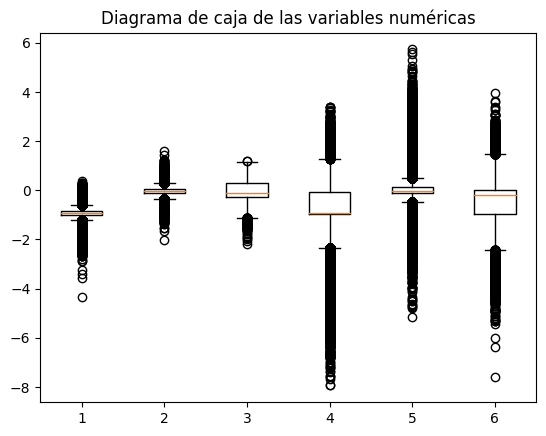

In [ ]:
#Realizar el diagrama de caja de cada variable
plt.boxplot(df[["back_x","back_y","back_z","thigh_x","thigh_y","thigh_z"]])
plt.title("Diagrama de caja de las variables numéricas")

### **Histograma de los tipos de actividad**
---

[Text(0.5, 1.0, 'Histograma de los tipos de actividad en el DataFrame')]

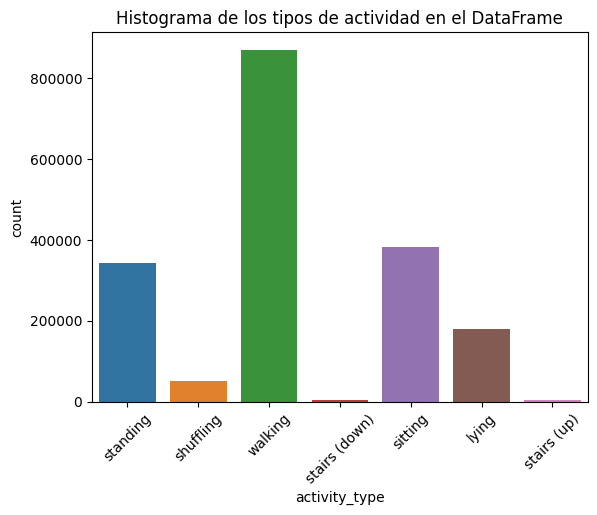

In [ ]:
#Realizar un histograma con los tipos de actividad
activity_freq = sns.countplot(data=df,x=df["activity_type"])
activity_freq.set_xticklabels(activity_freq.get_xticklabels(), rotation=45)
activity_freq.set(title="Histograma de los tipos de actividad en el DataFrame")

### **Diagrama de pastel sobre los tipos de actividad**
---

Text(0.5, 1.0, 'Distribución de cada tipo de actividad modelada')

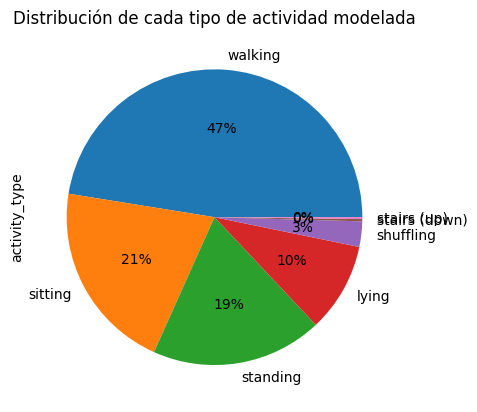

In [ ]:
#Graficar la frecuencia de cada actividad en un diagrama de pastel
df.activity_type.value_counts().plot(kind="pie",autopct='%.0f%%')
plt.title("Distribución de cada tipo de actividad modelada")

A partir de histograma y del diagrama pastel, se puede observar mediante estas representaciones la contabilidad con respecto al tipo de actividad. De dicha manera el histograma nos muestra la cantidad explicita de registros por actividad y en el diagrama pastel se observa a memdida de porcentaje dichos registros.

Gracias al histograma este nos ayuda a identificar patrones y anomalías en lo que tenemos, y nos permite comprender mejor lo que estamos analizando. El diagrama de pastel nos da una idea rápida de la distribución proporcional de los datos, pero sobre todo, la facilidad para sumar sectores, siempre y cuando la suma de en total su 100%

Se puede observar que la gran mayoría de las observaciones reconocieron la actividad de caminar, siendo casi el 50% de los datos. Las siguientes actividades más comunes fueron estar sentado y parado, seguido de acostado, arrastrar los pies y, por último subir y bajar escaleras. Si bien es cierto que en este punto del análisis aún no se puede inferir el porqué, el analizar ahora los valores de los acelerómetros podría dar una idea de cómo se selecciona el tipo de actividad dependiendo de los valores de aceleración.

### **Histograma de observaciones por paciente (número de pacientes)**
---

[Text(0.5, 1.0, 'Histograma de los registros por Paciente')]

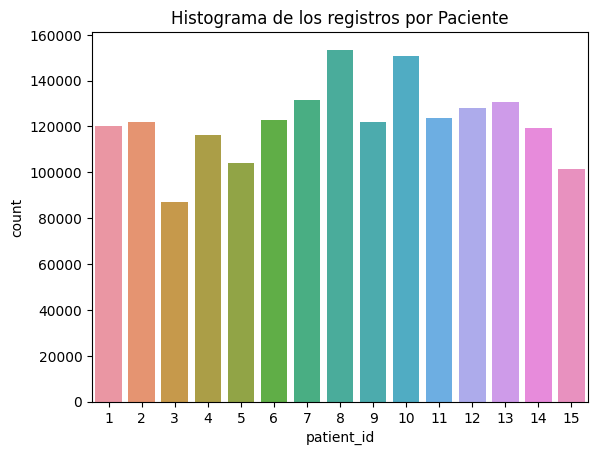

In [ ]:
#Realizar un histograma del número de registros de cada paciente
patients_freq = sns.countplot(data=df,x=df["patient_id"])
patients_freq.set(title="Histograma de los registros por Paciente")

Para comprender la información dentro de cada registro podemos observar como cada paciente contribuyó al total de registros, donde el paciente 8 comparado con el paciente 3 mantiene una diferencia mayor a comparación de otros pacientes. Cabe mencionar que dentro de los 15 pacientes, todos mantienen un número de registros alto, aproximadamente entre 9000 y 15000 registros, aunque ninguno con la misma cantidad.Sin embargo, todos los pacientes, a excepción del #3 tienen un número de registros relativamente similar, por lo que si se quisiera predecir por paciente, es importante considerar la cantidad de registros. Tomando en cuenta esta representación ahora se comprende qué paciente contribuye más al momento de observar los futuros gráficos.

### **Histogramas de cada sensor clasificado por tipo de actividad**
---

En base a estos 6 sensores que se observan, se decidió realizar un histograma con cada sensor, clasificándolo por tipo actividad, donde cada sensor es reconocido por las variables de:

* back_x
* back_y
* back_z
* thigh_x
* thigh_y
* thigh_z

Mediante a los diferentes colores que ayudan a la percepción de la distribucion de los datos, se puede observar como cada tipo de activad difiere dependiendo del sensor utilizado, el cual se puede observar en el eje x de cada histograma.

Text(0.5, 1.0, 'Histograma del sensor back_x clasificado por actividad')

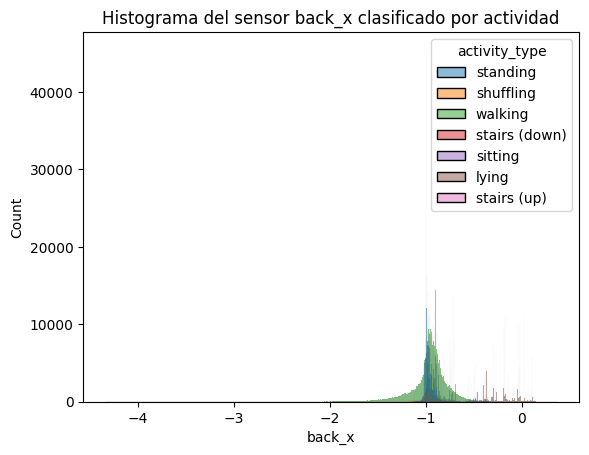

In [ ]:
#Analizar la distribución de cada uno de los datos
sns.histplot(data=df, x=df["back_x"], hue="activity_type")
plt.title("Histograma del sensor back_x clasificado por actividad")

En este histograma se puede observar la dispersión de los datos recabados por el sensor de la espalda, específicamente orientados en el eje x. De acuerdo con el sitio donde se obtuvo el dataset, se sabe que los valores positivos corresponden a aceleración hacia abajo, mientras que los valores negativos corresponden a aceleración hacia arriba. El histograma muestra que la mayoría de los registros de este eje se encuentran entre -2  y 0, teniendo la mayor concentración en -1. Además de eso, se puede ver que la gran mayoría de estos valores corresponden a estar parado o a estar caminando. Esta interpretación tiene sentido debido a que en ambos escenarios el sujeto de prueba se encuentra de pie, por lo que la aceleración en ese eje debería ir hacia arriba, y por ende es negativa. Por otro lado, también se puede ver que los valores de aceleración más cercanos a 0 corresponden a estar acostado, lo que también coincide con que no haya aceleración en ese eje puesto que estaría recargado a la superficie donde el sujeto de prueba se hubiera acostado. Finalmente los valores intermedios entre -1 y 0 corresponden al resto de las actividades en las que el sujeto de prueba se mueve tanto hacia arriba como hacia abajo.

Text(0.5, 1.0, 'Histograma del sensor back_y clasificado por actividad')

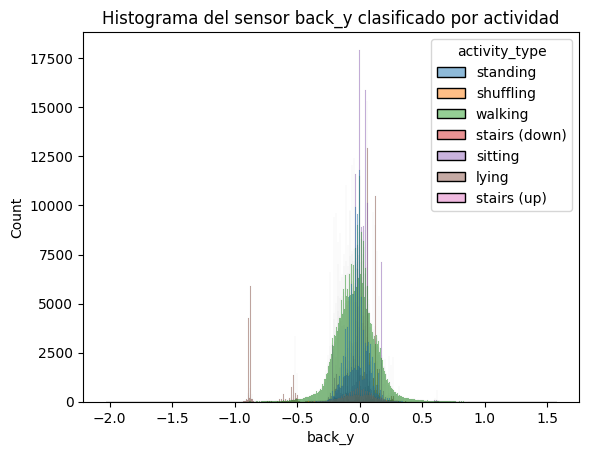

In [ ]:
sns.histplot(data=df, x=df["back_y"], hue="activity_type")
plt.title("Histograma del sensor back_y clasificado por actividad")

En este histograma se puede observar que el sensor de la espalda tiene mediciones más dispersas en el eje de y, el cual si es positivo significa aceleración hacia la izquierda y si es negativo hacia la derecha. Para este escenario, se puede observar que las mediciones tienden a 0, inclinándose un poco más hacia los valores negativos. Se puede observar que cuando los valores de la aceleración están cercanos a 0 el sujeto de prueba está parado, pero al igual puede estar caminando, y esto fluctúa entre -0.5 y 0.5. Esto se debe a que el sujeto puede estar caminando en cierta dirección, además de que es muy difícil caminar en una línea completamente recta, por lo que es entendible que cuando los valores oscilen en cantidades tan pequeñas se interprete que está parado o caminando. Para el resto de actividades, se puede observar que el sujeto está acostado cuando los valores de aceleración son menores a -0.5. Esto se debe a que el sujeto de prueba podría estar girando o moviéndose pero acostado, lo que explica que se haya seleccionado esta actividad.

Text(0.5, 1.0, 'Histograma del sensor back_z clasificado por actividad')

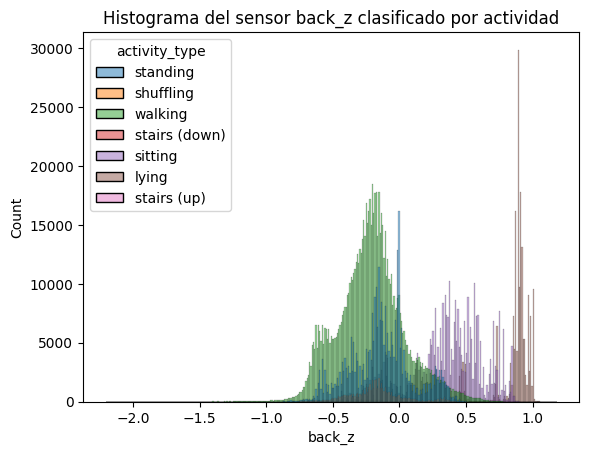

In [ ]:
sns.histplot(data=df, x=df["back_z"], hue="activity_type")
plt.title("Histograma del sensor back_z clasificado por actividad")

Finalmente, el último histograma del sensor de la espalda corresponde a la aceleración en el eje z. Se observa que la mayoría de registros se condensan entre -0.5 y 0. También se puede observar que cuando se eligió la actividad de caminar es desde cuando la aceleración en este eje oscila entre -1 y 0.5. Esto se debe a que al referirse a la dirección hacia adelante, puede interpretarse como que el sujeto está caminando, deteniéndose o incluso estando completamente parado. Por otro lado, se ve que cuando la aceleración es positiva y mayor a 0, se distingue también que está sentado o acostado. Esto se podría deber a que el sujeto al sentarse se inclina hacia adelante, o inclusive que se está poniendo de pie, lo que también aplica para cuando está acostado.

Text(0.5, 1.0, 'Histograma del sensor thigh_x clasificado por actividad')

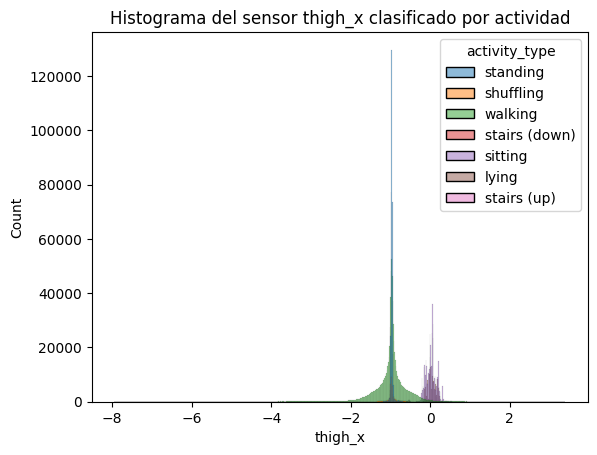

In [ ]:
sns.histplot(data=df, x=df["thigh_x"], hue="activity_type")
plt.title("Histograma del sensor thigh_x clasificado por actividad")

En el primer histograma del sensor de la cadera, se observan las mediciones del eje de x. Se puede ver que los valores fluctúan mucho, concentrándose la mayoría entre -2 y 0. Se puede ver que la gran mayoría de registros está cercana al -1 aproximadamente, y esta concentración de registros corresponde a caminar y estar parado. Sin embargo, los valores cercanos a 0 tienen que ver con estar sentado. Se sabe que el sensor de la cadera midiendo el eje x, el positivo significa aceleración hacia abajo y el negativo hacia arriba. Esto tiene sentido debido a que cuando el sujeto de prueba se sienta está agachándose y por consiguiente, incrementando su velocidad hacia abajo. Sin embargo, cuando el valor es negativo significa que se dirige hacia arriba. Y esto se relaciona con las actividades debido a que el movimiento de las piernas indicaría que hay una mayor aceleración, lo que significa que el sujeto está moviéndose o de pie. El resto de las actividades no se puede distinguir claramente en este histograma, por lo que no se pueden hacer interpretaciones justificadas sobre estos datos.

Text(0.5, 1.0, 'Histograma del sensor thigh_y clasificado por actividad')

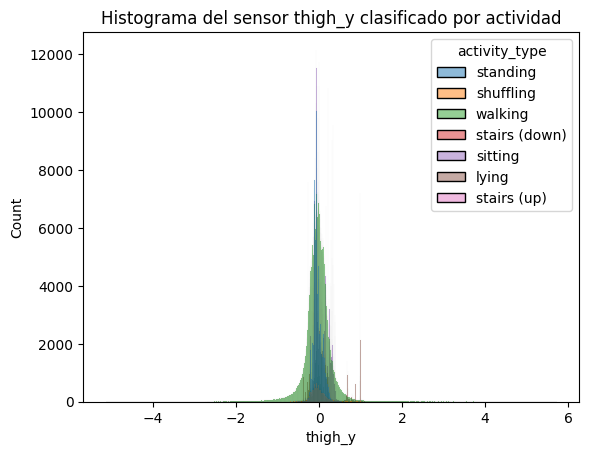

In [ ]:
sns.histplot(data=df, x=df["thigh_y"], hue="activity_type")
plt.title("Histograma del sensor thigh_y clasificado por actividad")

En cuanto al eje y del sensor de la cadera, el histograma muestra que los valores se concentran cercanos al 0, con valores que oscilan desde el -2 hasta el 2. El eje y de este sensor corresponde a la dirección derecha, por lo que los valores positivos indican que la aceleración es hacia esta dirección, y los negativos a la izquierda. Se vuelve a ver que la mayoría de los valores corresponden a caminar o estar parado, lo que tiene sentido debido a que una aceleración 0 indica que el sujeto no se está moviendo hacia ninguno de los lados, lo que se puede interpretar como estar caminando o parado, dependiendo del resto de los parámetros del sensor. Otra cosa observable en este histograma es que cuando la aceleración en este eje es positiva se interpreta que el sujeto está acostado. Esto, igualmente, depende de los otros parámetros pero se podría interpretar como que el sujeto de prueba se está girando sobre sí mismo acostado.

Text(0.5, 1.0, 'Histograma del sensor thigh_z clasificado por actividad')

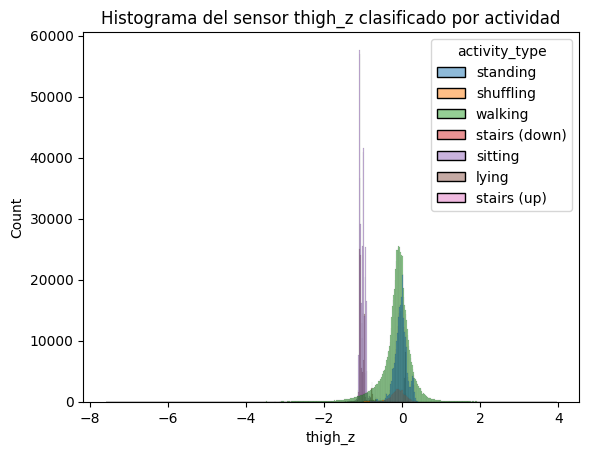

In [ ]:
sns.histplot(data=df, x=df["thigh_z"], hue="activity_type")
plt.title("Histograma del sensor thigh_z clasificado por actividad")

Finalmente, para el eje z del sensor de la cadera, se puede observar de nuevo, que la mayoría de los registros se concentran alrededor del 0, con valores oscilando de -2 a 2. Sin embargo, este histograma tiene una particularidad, y es que hay una gran cantidad de valores concentrados también en el -1. Estos valores corresponden a estar sentado, mientras que el resto a caminar o estar parado. Esta dirección se define como positivo ir con aceleración hacia atrás, y negativo hacia adelante. Esto se podría interpretar cómo que cuando la aceleración de este eje tiende a -1, el sujeto está sentado debido a que al sentarse mueve las piernas y el cuerpo, lo que hace que ese acelerómetro tome estos parámetros. Sin embargo, cuando la aceleración es más cercana a 0 es porque está caminando o parado ya que la cadera no tiene tanto movimiento cuando se realiza esta actividad. Sin embargo, se deben considerar también el resto de los parámetros para poder hacer una suposición acertada.

En conclusión, tras haber analizado por separado las mediciones de cada uno de los sensores en cada dirección, lo único que queda por mencionar es que las predicciones del tipo de actividad se hicieron en base a las 6 medidas en conjunto, ya que es muy difícil predecir el tipo de actividad realizada en base únicamente a un eje. Sin embargo, el analizar por separado cada uno de los ejes permite entender más a fondo a qué corresponden los valores, y tener una percepción y un panorama más completo de las mediciones y cómo reflejan el movimiento.

### **Análisis bivariante de los datos numéricos**
---

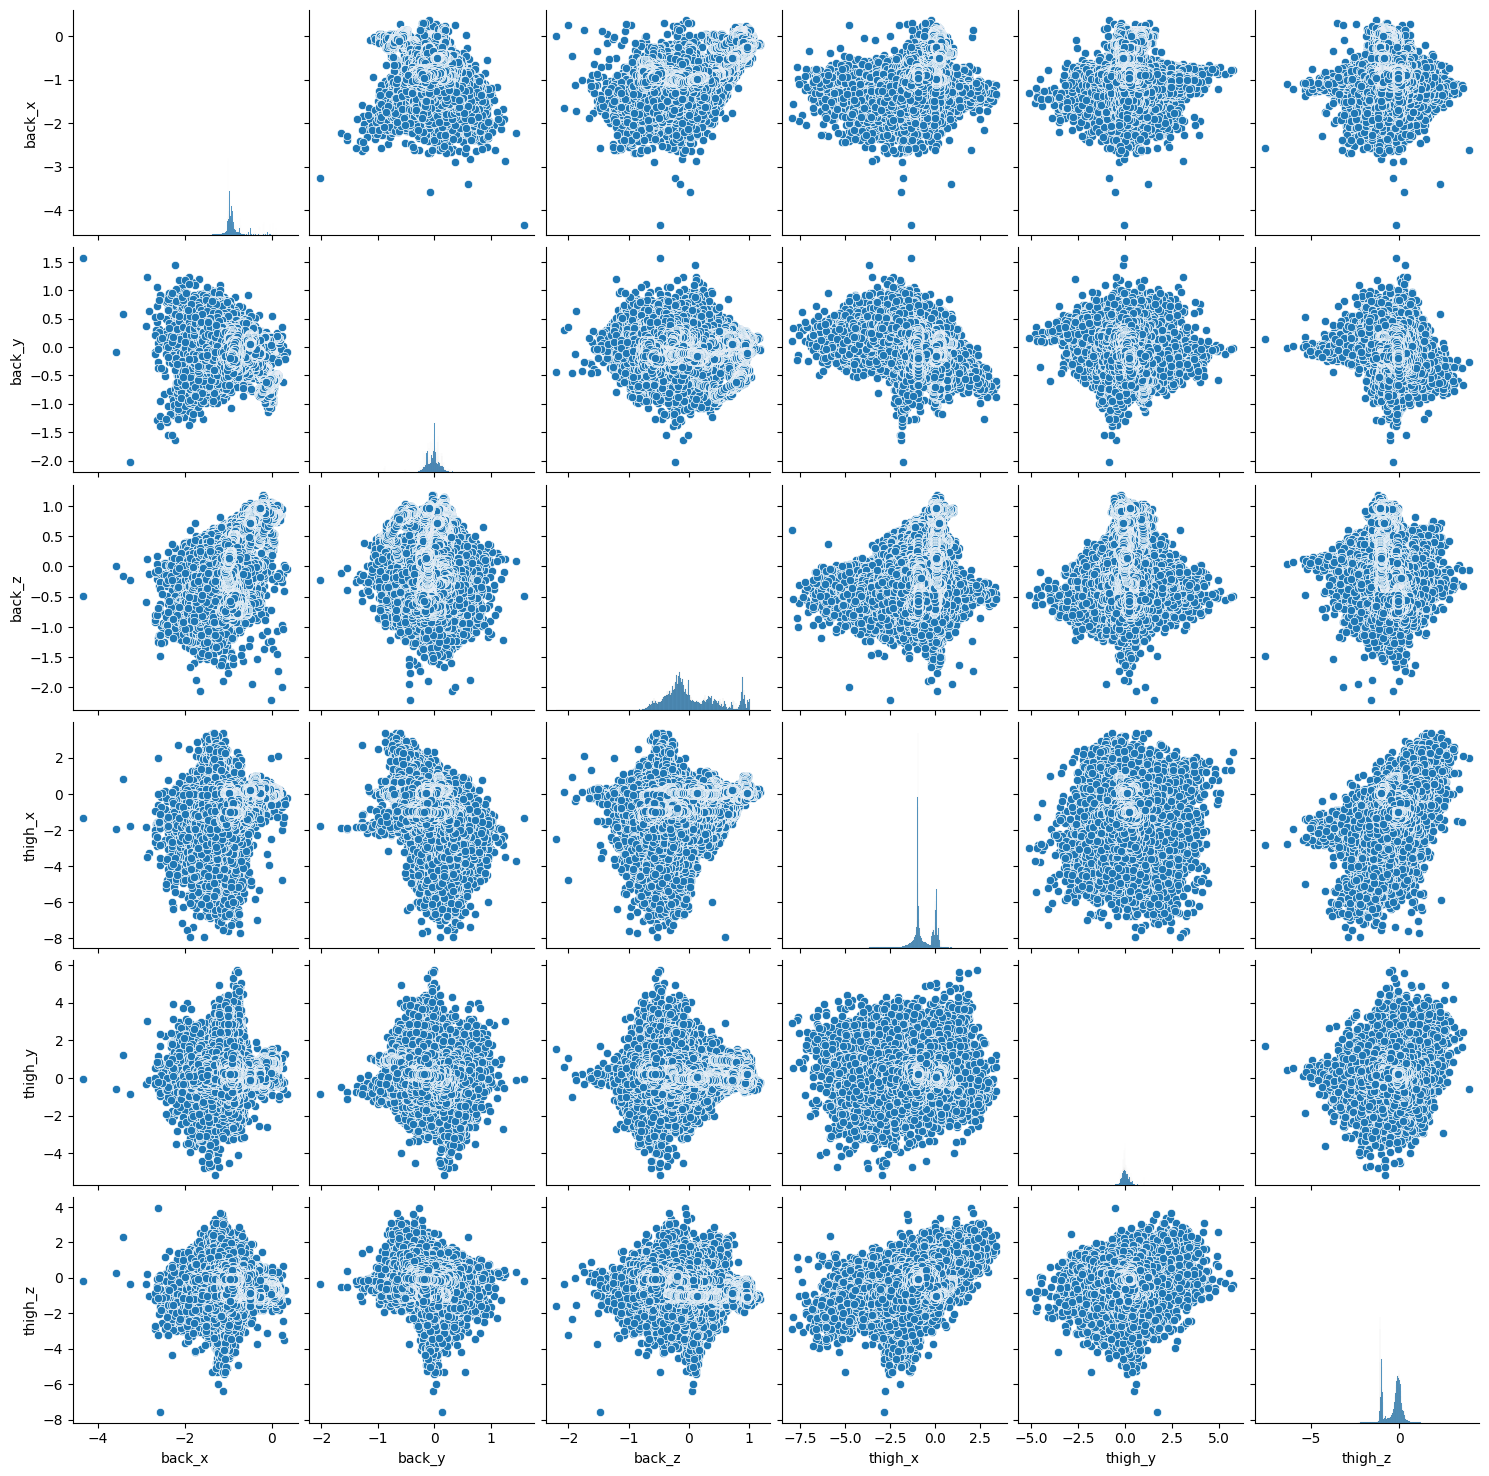

In [ ]:
#Analizar cómo están relacionadas las variables numéricas entre sí
df_num = df[["back_x","back_y","back_z","thigh_x","thigh_y","thigh_z"]]
sns.pairplot(df_num)

Para interpretar este análisis bivariante, se deben buscar variables que tengan correlación, es decir, que los datos formen una línea diagonal similar a una relación 1 a 1, que se puede expresar como y=x. Al observar estas gráficas, se puede decir que no hay variables correlacionadas, ya que la gran mayoría están dispersas alrededor de la gráfica y no forman adecuadamente una diagonal. Que no haya correlación entre las variables significa que estas serán valiosas para el modelo y poder predecir el tipo de actividad. Sin embargo, para poder comprobar que no haya correlación alguna, lo mejor que se puede realizar es una matriz de correlación y evaluar cada uno de los coeficientes de correlación entre todos los pares posibles de las variables del DataFrame.

### **Análisis de correlación de las variables**
---

Tras haber analizado los datos tanto visualmente como numéricamente, lo último que queda por hacer del análisis exploratorio es revisar si hay variables correlacionadas que pudieran llegar a inferir en el modelo de clasificación que se quiere realizar. Para poder hacer esto, se puede modelar la matriz de correlación con todas las variables numéricas, además de luego modelar dicha matriz en un mapa de calor donde se descubriría si hay variables correlacionadas o no.

In [ ]:
#Buscar si hay datos correlacionados con la matriz de correlación
df_num.corr()

,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z
back_x,1.000000,-0.104797,0.667065,0.533433,0.171067,-0.342677
back_y,-0.104797,1.000000,0.025312,-0.125428,-0.266343,-0.122763
back_z,0.667065,0.025312,1.000000,0.667972,0.106654,-0.599072
thigh_x,0.533433,-0.125428,0.667972,1.000000,0.251240,-0.585705
thigh_y,0.171067,-0.266343,0.106654,0.251240,1.000000,-0.076374
thigh_z,-0.342677,-0.122763,-0.599072,-0.585705,-0.076374,1.000000


<Axes: >

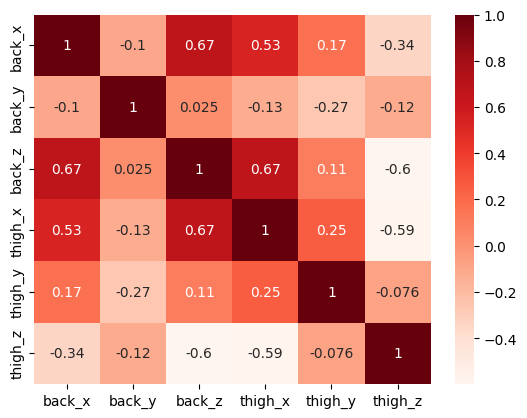

In [ ]:
#Graficar la matriz de correlación para ver de mejor forma los datos
sns.heatmap(df_num.corr(numeric_only=True), cmap="Reds", annot=True)

Tras haber obtenido y graficado la matriz de correlación, se puede observar que no hay variables altamente correlacionadas. Se considera que existe una alta correlación cuando el valor se encuentra entre 0.95 y 1 y, por defecto, entre -0.95 y -1. En este caso, en el heatmap graficado no se observan correlaciones en estos rangos, siendo el valor más cercano 0.67 (Back_z & Thigh_X, Back_X y Back_Z) Se puede observar que el resto de los coeficientes son más pequeños, siendo algunos muy cercanos a 0 y el resto oscilando entre estos extremos.

Esta matriz confirma que no hay variables con alta correlación, por lo que se podrían incluir en el modelo de clasificación que se usará para modelar el tipo de actividad realizada dependiendo de las medidas de aceleración de cada sensor.

## **Implementación de Modelos de Clasificación**
---


Tras haber analizado a detalle los datos con los que se trabajarán, lo siguiente por hacer es implementar varios algoritmos y modelos de clasificación para poder evaluar su desempeño y determinar qué modelo/algoritmo permite clasificar de mejor manera las actividades con los datos del conjunto.

Para evaluar el desempeño de cada modelo, se realizarán tres pruebas diferentes. Primeramente, se realizará una iteración simmple con el conjunto de datos original, después, se aplicará validación cruzada con los originales y, finalmente, se aplicará validación cruzada pero con el conjunto de datos balanceados.

Para determinar qué modelo es mejor, se usará el reporte de clasificación de Sci-Kit Learn, el cual muestra medidas de "Precision", "Recall" y el puntaje F-1, con lo que se podrá diferenciar el modelo más adecuado para los datos trabajados. Este reporte se explicará más a fondo a continuación.

Antes de proceder con la implementación de los modelos y su correspondiente evaluación, se debe generar el conjunto de datos balanceado. Para esto, se debe determinar qué forma de balanceo se utilizará, ya sea oversampling o subsampling. Estas técnicas se utilizan para balancear conjuntos de datos que no están equilibrados, y comparten la misma idea, la cual tiene que ver con regularizar el tamaño de muestras de cada elemento de la clase, ya sea incrementando las muestras para igualar a la clase con más elementos, o reduciendo el tamaño del resto de muestras para igualar a la clase con menor cantidad de elementos.

Para este escenario, al ver que se cuenta con un gran número de registros, se optó por el subsampleo como técnica de balanceo. Para reducir las muestras de cada clase al tamaño de la muestra con menos elementos, se eliminan de forma aleatoria registros del resto de clases hasta que tengan el mismo número de muestras. Esta implementación se muestra a continuación.

In [ ]:
#Definir los conjuntos de variables predictoras y de respuesta
xdf = df[["back_x","back_y","back_z","thigh_x","thigh_y","thigh_z"]]
ydf = df["label"]

In [ ]:
#Convertir las variables en arreglos para aplicar la clasificación en los modelos
x = xdf.to_numpy()
y = ydf.to_numpy()

In [ ]:
#Generar un dataframe balanceado para evaluar con ambos conjuntos de datos
df["label"].value_counts()

1    869690
7    381770
6    343198
8    178762
3     50892
5      4522
4      3726
Name: label, dtype: int64

In [ ]:
#Encontrar el número mínimo de valores para hacer el subsampling
label_min = df[df["label"] == 4]
min_count = len(label_min)

In [ ]:
#Generar el dataframe balanceado
columnas = [1,7,6,8,3,5]
df_balanceado = label_min

for col in columnas:
  clase_balanceada = resample(df[df["label"] == col], replace=False, n_samples=min_count, random_state=42)
  df_balanceado = pd.concat([df_balanceado, clase_balanceada])

In [ ]:
#Visualizar y comprobar que se tiene un dataframe balanceado
df_balanceado["label"].value_counts()

4    3726
1    3726
7    3726
6    3726
8    3726
3    3726
5    3726
Name: label, dtype: int64

[Text(0.5, 1.0, 'Histograma de los tipos de actividad en el DataFrame')]

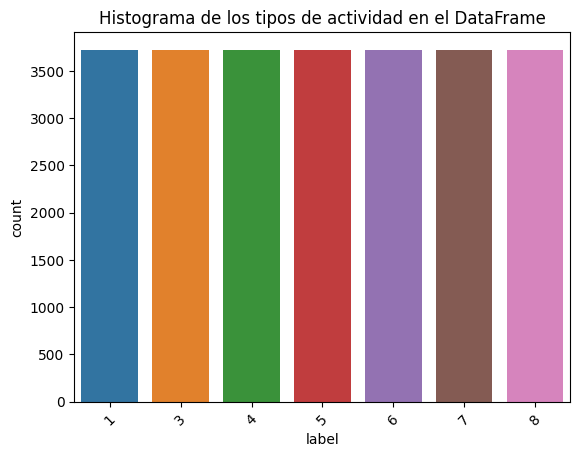

In [ ]:
#Realizar un histograma con los tipos de actividad
activity_freq = sns.countplot(data=df_balanceado,x=df_balanceado["label"])
activity_freq.set_xticklabels(activity_freq.get_xticklabels(), rotation=45)
activity_freq.set(title="Histograma de los tipos de actividad en el DataFrame")

In [ ]:
xbaldf = df_balanceado[["back_x","back_y","back_z","thigh_x","thigh_y","thigh_z"]]
ybaldf = df_balanceado["label"]

In [ ]:
xbal = xbaldf.to_numpy()
ybal = ybaldf.to_numpy()

Tras haber generado el conjunto de datos balanceado, lo siguiente por hacer es implementar cada modelo/algoritmo de clasificación para obtener sus puntajes y evaluarlos.

El reporte de clasificación que se usará cuenta con 3 medidas principales:
* Precision: Medida que demuestra la capacidad del modelo para predecir correctamente la pertenencia de un elemento a dicha clase, los resultados oscilan entre 0 y 1.
* Recall: Medida que demuestra la tasa de verdaderos positivos con respecto al total de elementos verdaderamente positivos y los falsos positivos. Igualmente se representa con valores entre 0 y 1.
* F-1 Score: Medida que permite representar la precisión y recuperación del modelo de clasificación.

Estas tres medidas son calculadas para cada elemento de la clase a clasificar, y se busca encontrar el modelo que pueda tener el valor más alto de precision y recall, por lo que estos serán los criterios a evaluar cuando se lleve a cabo la implementación de cada modelo.

### **Random Forest Classifier**
---
El RFC, o Random Forest Classifier es un algoritmo de clasificación que funciona mediante la generación de árboles de decisión generados aleatoriamente para poder clasificar los datos en conjuntos. Estos árboles se generan con datos y variables aleatorias, y utilizan las predicciones/resultados de los otros árboles de decisión para generar la predicción final. Cada árbol selecciona una clase y la mayoría de selecciones termina generando los criterios de clasificación.

Algunos de sus parámetros más relevantes son los siguientes:

n_estimators: Define el número de árboles de decisión que se van a generar.

max_depth: Define la profundidad de los árboles de decisión, si no se especifica la profundidad será la máxima posible.

criterion: Define el criterio para medir la calidad de las predicciones en un split de datos del árbol respectivo.

In [ ]:
#Verificar el funcionamiento del RFC con los datos del conjunto sin balancear
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.2, random_state=42)
clf = RandomForestClassifier()
clf.fit(xtrain,ytrain)
ypred = clf.predict(xtest)

In [ ]:
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

           1       0.92      0.97      0.95    173881
           3       0.65      0.08      0.15     10262
           4       0.87      0.14      0.25       719
           5       0.88      0.07      0.12       907
           6       0.90      0.91      0.90     68695
           7       1.00      1.00      1.00     76271
           8       1.00      1.00      1.00     35777

    accuracy                           0.94    366512
   macro avg       0.89      0.60      0.62    366512
weighted avg       0.93      0.94      0.93    366512



In [ ]:
#Verificar el funcionamiento del RFC sin balancear por medio de validación cruzada
kfolds = KFold(n_splits=5, shuffle=True)
clfytest = []
clfypred = []

for train_i, test_i in kfolds.split(x,y):
  #Preparar los datos de entrenamiento
  xtrain = x[train_i,:]
  ytrain = y[train_i]

  #Preparar el modelo
  clf_i = RandomForestClassifier()
  clf_i.fit(xtrain,ytrain)

  #Definir los conjuntos de prueba
  xtest = x[test_i,:]
  ytest = y[test_i]

  #Evaluar los resultados
  ypred = clf_i.predict(xtest)
  clfytest.append(ytest)
  clfypred.append(ypred)

print(classification_report(np.concatenate(clfytest),np.concatenate(clfypred)))

              precision    recall  f1-score   support

           1       0.92      0.97      0.95    869690
           3       0.66      0.09      0.15     50892
           4       0.85      0.12      0.21      3726
           5       0.82      0.06      0.11      4522
           6       0.90      0.91      0.90    343198
           7       1.00      1.00      1.00    381770
           8       1.00      1.00      1.00    178762

    accuracy                           0.94   1832560
   macro avg       0.88      0.59      0.62   1832560
weighted avg       0.93      0.94      0.93   1832560



In [ ]:
#Verificar el funcionamiento del RFC balanceado por medio de validación cruzada
kfolds = KFold(n_splits=5, shuffle=True)
clfytest = []
clfypred = []

for train_i, test_i in kfolds.split(xbal,ybal):
  #Preparar los datos de entrenamiento
  xtrain = xbal[train_i,:]
  ytrain = ybal[train_i]

  #Preparar el modelo
  clf_i = RandomForestClassifier()
  clf_i.fit(xtrain,ytrain)

  #Definir los conjuntos de prueba
  xtest = xbal[test_i,:]
  ytest = ybal[test_i]

  #Evaluar los resultados
  ypred = clf_i.predict(xtest)
  clfytest.append(ytest)
  clfypred.append(ypred)

print(classification_report(np.concatenate(clfytest),np.concatenate(clfypred)))

              precision    recall  f1-score   support

           1       0.63      0.60      0.62      3726
           3       0.56      0.60      0.58      3726
           4       0.74      0.76      0.75      3726
           5       0.67      0.62      0.64      3726
           6       0.79      0.81      0.80      3726
           7       1.00      1.00      1.00      3726
           8       1.00      1.00      1.00      3726

    accuracy                           0.77     26082
   macro avg       0.77      0.77      0.77     26082
weighted avg       0.77      0.77      0.77     26082



### **Stochastic Gradient Descent**
---
El Stochastic Gradient Descent es un algoritmo de clasificación el cual se basa en el descenso de gradiente para encontrar los parámetros del modelo y ajustarlos, al igual que para entrenar los datos Permite procesar únicamente un set de datos aleatorio, generando una función y optimizándola para encontrar la menor pérdida entre los valores actuales y las predicciones.

Algunos de los parámetros más importantes del SGD son los siguientes:

loss: Define la función de pérdida que se optimizará, permitiendo elegir entre varias funciones.

alpha: El coeficiente con el que se va a implementar el cambio en el gradiente de la función.

max_iter: El número máximo de iteraciones que utilizará el modelo.

In [ ]:
#Verificar el funcionamiento del SGD con los datos del conjunto sin balancear
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.2, random_state=42)
clf = SGDClassifier()
clf.fit(xtrain,ytrain)
ypred = clf.predict(xtest)

In [ ]:
print(classification_report(ytest,ypred, zero_division=0))

              precision    recall  f1-score   support

           1       0.68      0.98      0.80    173881
           3       0.00      0.00      0.00     10262
           4       0.00      0.00      0.00       719
           5       0.00      0.00      0.00       907
           6       0.00      0.00      0.00     68695
           7       0.95      0.97      0.96     76271
           8       0.95      0.98      0.96     35777

    accuracy                           0.76    366512
   macro avg       0.37      0.42      0.39    366512
weighted avg       0.61      0.76      0.67    366512



In [ ]:
#Verificar el funcionamiento del SGD sin balancear por medio de validación cruzada
kfolds = KFold(n_splits=5, shuffle=True)
clfytest = []
clfypred = []
clf_i = SGDClassifier()

for train_i, test_i in kfolds.split(x,y):
  #Preparar los datos de entrenamiento
  xtrain = x[train_i,:]
  ytrain = y[train_i]

  #Preparar el modelo
  clf_i.fit(xtrain,ytrain)

  #Definir los conjuntos de prueba
  xtest = x[test_i,:]
  ytest = y[test_i]

  #Evaluar los resultados
  ypred = clf_i.predict(xtest)
  clfytest.append(ytest)
  clfypred.append(ypred)

print(classification_report(np.concatenate(clfytest),np.concatenate(clfypred),zero_division=0))

              precision    recall  f1-score   support

           1       0.68      0.98      0.80    869690
           3       0.00      0.00      0.00     50892
           4       0.00      0.00      0.00      3726
           5       0.00      0.00      0.00      4522
           6       0.00      0.00      0.00    343198
           7       0.95      0.97      0.96    381770
           8       0.95      0.98      0.96    178762

    accuracy                           0.76   1832560
   macro avg       0.37      0.42      0.39   1832560
weighted avg       0.61      0.76      0.68   1832560



In [ ]:
#Implementar el SGD con el conjunto de datos balanceado
kfolds = KFold(n_splits=5, shuffle=True)
clfytest = []
clfypred = []
clf_i = SGDClassifier()

for train_i, test_i in kfolds.split(xbal,ybal):
  #Preparar los datos de entrenamiento
  xtrain = xbal[train_i,:]
  ytrain = ybal[train_i]

  #Preparar el modelo
  clf_i.fit(xtrain,ytrain)

  #Definir los conjuntos de prueba
  xtest = xbal[test_i,:]
  ytest = ybal[test_i]

  #Evaluar los resultados
  ypred = clf_i.predict(xtest)
  clfytest.append(ytest)
  clfypred.append(ypred)

print(classification_report(np.concatenate(clfytest),np.concatenate(clfypred),zero_division=0))

              precision    recall  f1-score   support

           1       0.21      0.35      0.26      3726
           3       0.24      0.17      0.20      3726
           4       0.30      0.40      0.34      3726
           5       0.34      0.16      0.22      3726
           6       0.38      0.28      0.32      3726
           7       0.91      0.95      0.93      3726
           8       0.96      0.98      0.97      3726

    accuracy                           0.47     26082
   macro avg       0.48      0.47      0.46     26082
weighted avg       0.48      0.47      0.46     26082



### **MLP Classifier**
---
El clasificador MLP, también conocido como el clasificador del perceptrón multicapa es una red neuronal que permite generar modelos con datos con relaciones complejas. Este algoritmo utiliza distintas capas con cierto número de neuronas para poder encontrar las relaciones entre las variables predictoras y después pasar esa información a la siguiente capa hasta encontrar una función óptima para modelar la pertenencia a cada clase.

Algunos de los parámetros más importantes son los siguientes:

hidden_layer_sizes: El tamaño de capas y neuronas de la red del clasificador. Define el número de capas y de neuronas por capa.

activation: Función de activación para cada capa de procesamiento, ofreciendo varias funciones dependiendo del conjunto de datos.

alpha: El coeficiente con el que se va a implementar el cambio en el gradiente de la función.

In [ ]:
#Verificar el funcionamiento del SGD con los datos del conjunto sin balancear
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.2, random_state=42)
clf = MLPClassifier(hidden_layer_sizes=(25,25),activation="relu")
clf.fit(xtrain,ytrain)
ypred = clf.predict(xtest)

In [ ]:
print(classification_report(ytest,ypred, zero_division=0))

              precision    recall  f1-score   support

           1       0.93      0.94      0.93    173881
           3       0.29      0.00      0.00     10262
           4       0.53      0.01      0.02       719
           5       0.00      0.00      0.00       907
           6       0.81      0.93      0.87     68695
           7       1.00      1.00      1.00     76271
           8       1.00      1.00      1.00     35777

    accuracy                           0.92    366512
   macro avg       0.65      0.55      0.55    366512
weighted avg       0.91      0.92      0.91    366512



In [ ]:
#Verificar el funcionamiento del SGD sin balancear por medio de validación cruzada
kfolds = KFold(n_splits=5, shuffle=True)
clfytest = []
clfypred = []
clf_i = MLPClassifier(hidden_layer_sizes=(25,25),activation="relu")

for train_i, test_i in kfolds.split(x,y):
  #Preparar los datos de entrenamiento
  xtrain = x[train_i,:]
  ytrain = y[train_i]

  #Preparar el modelo
  clf_i.fit(xtrain,ytrain)

  #Definir los conjuntos de prueba
  xtest = x[test_i,:]
  ytest = y[test_i]

  #Evaluar los resultados
  ypred = clf_i.predict(xtest)
  clfytest.append(ytest)
  clfypred.append(ypred)

print(classification_report(np.concatenate(clfytest),np.concatenate(clfypred),zero_division=0))

              precision    recall  f1-score   support

           1       0.92      0.95      0.93    869690
           3       0.33      0.00      0.00     50892
           4       0.51      0.02      0.03      3726
           5       0.47      0.00      0.00      4522
           6       0.84      0.90      0.87    343198
           7       1.00      1.00      1.00    381770
           8       1.00      1.00      1.00    178762

    accuracy                           0.93   1832560
   macro avg       0.72      0.55      0.55   1832560
weighted avg       0.91      0.93      0.91   1832560



In [ ]:
#Implementar el SGD con el conjunto de datos balanceado
kfolds = KFold(n_splits=5, shuffle=True)
clfytest = []
clfypred = []
clf_i = MLPClassifier(hidden_layer_sizes=(25,25),activation="relu", max_iter=500)

for train_i, test_i in kfolds.split(xbal,ybal):
  #Preparar los datos de entrenamiento
  xtrain = xbal[train_i,:]
  ytrain = ybal[train_i]

  #Preparar el modelo
  clf_i.fit(xtrain,ytrain)

  #Definir los conjuntos de prueba
  xtest = xbal[test_i,:]
  ytest = ybal[test_i]

  #Evaluar los resultados
  ypred = clf_i.predict(xtest)
  clfytest.append(ytest)
  clfypred.append(ypred)

print(classification_report(np.concatenate(clfytest),np.concatenate(clfypred),zero_division=0))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.61      0.49      0.54      3726
           3       0.48      0.51      0.50      3726
           4       0.64      0.65      0.65      3726
           5       0.55      0.51      0.53      3726
           6       0.68      0.81      0.74      3726
           7       0.99      0.99      0.99      3726
           8       1.00      1.00      1.00      3726

    accuracy                           0.71     26082
   macro avg       0.71      0.71      0.71     26082
weighted avg       0.71      0.71      0.71     26082



### **Adaboost**
---

AdaBoostClassifier es un algoritmo de ensamble de máquinas de aprendizaje que se utiliza para mejorar el rendimiento de los modelos de clasificación débiles, los "clasificadores débiles" son modelos de aprendizaje que tienen un rendimiento ligeramente mejor que una suposición aleatoria, como árboles de decisión poco profundos.

Parámetros clave de AdaBoostClassifier:

* base_estimator: El tipo de clasificador débil que se utilizará en cada iteración. Por defecto, se usa un árbol de decisión con profundidad 1.
* n_estimators: El número de clasificadores débiles que se entrenarán. Cuantos más estimadores, más preciso puede ser el modelo, pero también puede aumentar el riesgo de sobreajuste.
* learning_rate: Un parámetro que controla la contribución de cada clasificador débil. Un valor menor reduce la contribución de cada clasificador y puede ayudar a evitar el sobreajuste.
* random_state: Controla la aleatoriedad en la selección de muestras

In [ ]:
#Verificar el funcionamiento del SGD con los datos del conjunto sin balancear
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.2, random_state=42)
# Crear un clasificador AdaBoost
adaboost_classifier = AdaBoostClassifier(n_estimators=50, random_state=42)

# Entrenar el clasificador en el conjunto de entrenamiento
adaboost_classifier.fit(xtrain, ytrain)

# Realizar predicciones en el conjunto de prueba
y_pred = adaboost_classifier.predict(xtest)

# Mostrar un informe de clasificación
classification_rep = classification_report(ytest, y_pred, zero_division=0)
print('\nInforme de Clasificación Adaboost sin balanceo, sin KFolds:\n', classification_rep)


Informe de Clasificación Adaboost sin balanceo, sin KFolds:
               precision    recall  f1-score   support

           1       0.67      0.97      0.80    173881
           3       0.00      0.00      0.00     10262
           4       0.00      0.00      0.00       719
           5       0.00      0.00      0.00       907
           6       0.00      0.00      0.00     68695
           7       0.92      0.79      0.85     76271
           8       0.70      1.00      0.83     35777

    accuracy                           0.72    366512
   macro avg       0.33      0.39      0.35    366512
weighted avg       0.58      0.72      0.63    366512



In [ ]:
#Verificar el funcionamiento del AdaBoost sin balancear por medio de validación cruzada
kfolds = KFold(n_splits=5, shuffle=True)
clfytest = []
clfypred = []
clf_i = AdaBoostClassifier(n_estimators=50, random_state=42)

for train_i, test_i in kfolds.split(x,y):
  #Preparar los datos de entrenamiento
  xtrain = x[train_i,:]
  ytrain = y[train_i]

  #Preparar el modelo
  clf_i.fit(xtrain,ytrain)

  #Definir los conjuntos de prueba
  xtest = x[test_i,:]
  ytest = y[test_i]

  #Evaluar los resultados
  ypred = clf_i.predict(xtest)
  clfytest.append(ytest)
  clfypred.append(ypred)

print('\nInforme de Clasificación Adaboost sin balanceo, con KFolds:\n',classification_report(np.concatenate(clfytest),np.concatenate(clfypred),zero_division=0))


Informe de Clasificación Adaboost sin balanceo, con KFolds:
               precision    recall  f1-score   support

           1       0.68      0.99      0.80    869690
           3       0.00      0.00      0.00     50892
           4       0.00      0.00      0.00      3726
           5       0.00      0.00      0.00      4522
           6       0.00      0.00      0.00    343198
           7       0.96      0.88      0.92    381770
           8       0.80      0.99      0.89    178762

    accuracy                           0.75   1832560
   macro avg       0.35      0.41      0.37   1832560
weighted avg       0.60      0.75      0.66   1832560



In [ ]:
#Implementar el SGD con el conjunto de datos balanceado
kfolds = KFold(n_splits=5, shuffle=True)
clfytest = []
clfypred = []
clf_i = AdaBoostClassifier(n_estimators=50, random_state=42)

for train_i, test_i in kfolds.split(xbal,ybal):
  #Preparar los datos de entrenamiento
  xtrain = xbal[train_i,:]
  ytrain = ybal[train_i]

  #Preparar el modelo
  clf_i.fit(xtrain,ytrain)

  #Definir los conjuntos de prueba
  xtest = xbal[test_i,:]
  ytest = ybal[test_i]

  #Evaluar los resultados
  ypred = clf_i.predict(xtest)
  clfytest.append(ytest)
  clfypred.append(ypred)

print('\nInforme de Clasificación Adaboost con balanceo, con KFolds:\n',classification_report(np.concatenate(clfytest),np.concatenate(clfypred),zero_division=0))


Informe de Clasificación Adaboost con balanceo, con KFolds:
               precision    recall  f1-score   support

           1       0.41      0.00      0.01      3726
           3       0.20      0.59      0.30      3726
           4       0.45      0.02      0.05      3726
           5       0.20      0.20      0.20      3726
           6       0.19      0.19      0.19      3726
           7       0.87      0.95      0.91      3726
           8       0.96      0.91      0.93      3726

    accuracy                           0.41     26082
   macro avg       0.47      0.41      0.37     26082
weighted avg       0.47      0.41      0.37     26082



### **Regresión Logística**
---
La regresión logística es un algoritmo de clasificación que consiste en el modelado de funciones que determinen la pertenencia a un elemento de una clase en particular. Estas funciones se generan por medio de una función sigmoide, la cual se genera en base a los datos y determina el conjunto de pesos mínimos para cada elemento de cada clase.

Los parámetros más importantes de la función son los siguientes:

* tol: La tolerancia del criterio de detenimiento.

* max_iter: Número máximo de iteraciones a utilizar en la regresión logística.

In [ ]:
#Realizar el modelo de regresión logística con el conjunto de datos original
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# Crear y entrenar el modelo de regresión logística
reg_log = LogisticRegression(max_iter=500)
reg_log.fit(x_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = reg_log.predict(x_test)

print('\nInforme de Clasificación de Regresión Logística sin balanceo, sin KFolds:\n', classification_report(y_test, y_pred, zero_division=1))


Informe de Clasificación de Regresión Logística sin balanceo, sin KFolds:
               precision    recall  f1-score   support

           1       0.68      0.97      0.80    173881
           3       1.00      0.00      0.00     10262
           4       0.00      0.00      0.00       719
           5       1.00      0.00      0.00       907
           6       0.39      0.04      0.08     68695
           7       0.97      0.97      0.97     76271
           8       0.96      0.98      0.97     35777

    accuracy                           0.76    366512
   macro avg       0.72      0.42      0.40    366512
weighted avg       0.72      0.76      0.69    366512



In [ ]:
#Generar el modelo de regresión logística y evaluarlo con validación cruzada
kfolds = KFold(n_splits=5, shuffle=True)
clfytest = []
clfypred = []
clf_i = LogisticRegression(max_iter=500)

for train_i, test_i in kfolds.split(x,y):
  #Preparar los datos de entrenamiento
  xtrain = x[train_i,:]
  ytrain = y[train_i]

  #Preparar el modelo
  clf_i.fit(xtrain,ytrain)

  #Definir los conjuntos de prueba
  xtest = x[test_i,:]
  ytest = y[test_i]

  #Evaluar los resultados
  ypred = clf_i.predict(xtest)
  clfytest.append(ytest)
  clfypred.append(ypred)

print('\nInforme de Clasificación de Regresión Logística sin balanceo, con KFolds:\n',classification_report(np.concatenate(clfytest),np.concatenate(clfypred),zero_division=0))


Informe de Clasificación de Regresión Logística sin balanceo, con KFolds:
               precision    recall  f1-score   support

           1       0.68      0.97      0.80    869690
           3       0.00      0.00      0.00     50892
           4       0.00      0.00      0.00      3726
           5       0.00      0.00      0.00      4522
           6       0.38      0.04      0.07    343198
           7       0.97      0.98      0.97    381770
           8       0.96      0.98      0.97    178762

    accuracy                           0.76   1832560
   macro avg       0.43      0.42      0.40   1832560
weighted avg       0.69      0.76      0.69   1832560



In [ ]:
#Realizar el modelo de regresión logística con los datos balanceados y evaluarlo con validación cruzada
kfolds = KFold(n_splits=5, shuffle=True)
clfytest = []
clfypred = []
clf_i = LogisticRegression(max_iter=500)

for train_i, test_i in kfolds.split(xbal,ybal):
  #Preparar los datos de entrenamiento
  xtrain = xbal[train_i,:]
  ytrain = ybal[train_i]

  #Preparar el modelo
  clf_i.fit(xtrain,ytrain)

  #Definir los conjuntos de prueba
  xtest = xbal[test_i,:]
  ytest = ybal[test_i]

  #Evaluar los resultados
  ypred = clf_i.predict(xtest)
  clfytest.append(ytest)
  clfypred.append(ypred)

print('\nInforme de Clasificación de Regresión Logística con balanceo, con KFolds:\n',classification_report(np.concatenate(clfytest),np.concatenate(clfypred),zero_division=0))


Informe de Clasificación de Regresión Logística con balanceo, con KFolds:
               precision    recall  f1-score   support

           1       0.26      0.19      0.22      3726
           3       0.31      0.20      0.24      3726
           4       0.45      0.60      0.52      3726
           5       0.42      0.32      0.36      3726
           6       0.38      0.56      0.45      3726
           7       0.95      0.97      0.96      3726
           8       0.97      0.98      0.98      3726

    accuracy                           0.55     26082
   macro avg       0.53      0.55      0.53     26082
weighted avg       0.53      0.55      0.53     26082



### **K-NN**
---
Es un tipo de aprendizaje basado en instancias o aprendizaje no generalizado. No intenta construir un model interno general, pero simplemente guarda instancias de los datos de entrenamiento. La clasificación es computada de un voto por mayoría simple de los vecinos más cercanos de cada punto. Los hiperparámetros más importantes son los siguientes:
* Number of neighbors: Número de vecinos más cercanos que se consideraran para realizar la clasificación
* Metric: Fórmula de medida para calcular la distancia entre vecinos.
* Weights: Fórmula o esquema para medir y calcular los pesos entre los vecinos.

In [ ]:
#Realizar el modelo de KNN con el conjunto de datos original
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# Crear y entrenar el modelo de KNN
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(x_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = knn_classifier.predict(x_test)

print('\nInforme de Clasificación de KNN sin balanceo, sin KFolds:\n', classification_report(y_test, y_pred, zero_division=1))


Informe de Clasificación de KNN sin balanceo, sin KFolds:
               precision    recall  f1-score   support

           1       0.93      0.95      0.94    173881
           3       0.42      0.21      0.28     10262
           4       0.58      0.29      0.39       719
           5       0.55      0.17      0.26       907
           6       0.88      0.91      0.89     68695
           7       1.00      1.00      1.00     76271
           8       1.00      1.00      1.00     35777

    accuracy                           0.93    366512
   macro avg       0.77      0.65      0.68    366512
weighted avg       0.93      0.93      0.93    366512



In [ ]:
#Generar el modelo de KNN y evaluarlo con validación cruzada
kfolds = KFold(n_splits=5, shuffle=True)
clfytest = []
clfypred = []
clf_i = KNeighborsClassifier(n_neighbors=3)

for train_i, test_i in kfolds.split(x,y):
  #Preparar los datos de entrenamiento
  xtrain = x[train_i,:]
  ytrain = y[train_i]

  #Preparar el modelo
  clf_i.fit(xtrain,ytrain)

  #Definir los conjuntos de prueba
  xtest = x[test_i,:]
  ytest = y[test_i]

  #Evaluar los resultados
  ypred = clf_i.predict(xtest)
  clfytest.append(ytest)
  clfypred.append(ypred)

print('\nInforme de Clasificación de KNN sin balanceo, con KFolds:\n',classification_report(np.concatenate(clfytest),np.concatenate(clfypred),zero_division=0))


Informe de Clasificación de KNN sin balanceo, con KFolds:
               precision    recall  f1-score   support

           1       0.93      0.95      0.94    869690
           3       0.41      0.21      0.27     50892
           4       0.58      0.27      0.37      3726
           5       0.52      0.15      0.24      4522
           6       0.88      0.91      0.89    343198
           7       1.00      1.00      1.00    381770
           8       1.00      1.00      1.00    178762

    accuracy                           0.93   1832560
   macro avg       0.76      0.64      0.67   1832560
weighted avg       0.93      0.93      0.93   1832560



In [ ]:
#Realizar el modelo de KNN con los datos balanceados y evaluarlo con validación cruzada
kfolds = KFold(n_splits=5, shuffle=True)
clfytest = []
clfypred = []
clf_i = KNeighborsClassifier(n_neighbors=3)

for train_i, test_i in kfolds.split(xbal,ybal):
  #Preparar los datos de entrenamiento
  xtrain = xbal[train_i,:]
  ytrain = ybal[train_i]

  #Preparar el modelo
  clf_i.fit(xtrain,ytrain)

  #Definir los conjuntos de prueba
  xtest = xbal[test_i,:]
  ytest = ybal[test_i]

  #Evaluar los resultados
  ypred = clf_i.predict(xtest)
  clfytest.append(ytest)
  clfypred.append(ypred)

print('\nInforme de Clasificación de Regresión Logística con balanceo, con KFolds:\n',classification_report(np.concatenate(clfytest),np.concatenate(clfypred),zero_division=0))


Informe de Clasificación de Regresión Logística con balanceo, con KFolds:
               precision    recall  f1-score   support

           1       0.56      0.60      0.58      3726
           3       0.53      0.50      0.51      3726
           4       0.75      0.74      0.74      3726
           5       0.68      0.59      0.63      3726
           6       0.72      0.81      0.76      3726
           7       0.99      1.00      1.00      3726
           8       1.00      1.00      1.00      3726

    accuracy                           0.75     26082
   macro avg       0.75      0.75      0.75     26082
weighted avg       0.75      0.75      0.75     26082



### **Gradient Boosting**
---
Gradient Boosting es una técnica de aprendizaje automático para problemas de clasificación y regresión, que construye un modelo predictivo en forma de un ensamblado de modelos débiles, típicamente árboles de decisión. Se trata de un algoritmo que mejora iterativamente la precisión de un modelo al optimizar el error residual de las predicciones previas.

Los parámetros más relevantes de este modelo son los siguientes:
* Número de estimadores: La cantidad de estimadores/elementos de aprendizaje que serán utilizados para obtener los resultados.
* Learning Rate: Razón de cambio de cada uno de los estimadores para el ensamble final.
* Depths: La profundidad de cada uno de los estimadores en el ensamble.

In [ ]:
#Realizar el modelo de gradient boosting con el conjunto de datos original
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# Crear y entrenar el modelo de gradient boosting
gbc =  GradientBoostingClassifier(n_estimators=10)
gbc.fit(x_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = gbc.predict(x_test)

print('\nInforme de Clasificación de KNN sin balanceo, sin KFolds:\n', classification_report(y_test, y_pred, zero_division=1))


Informe de Clasificación de KNN sin balanceo, sin KFolds:
               precision    recall  f1-score   support

           1       0.88      0.91      0.90    173881
           3       1.00      0.00      0.00     10262
           4       0.00      0.00      0.00       719
           5       0.00      0.00      0.00       907
           6       0.74      0.80      0.77     68695
           7       0.99      0.99      0.99     76271
           8       0.99      0.99      0.99     35777

    accuracy                           0.89    366512
   macro avg       0.66      0.53      0.52    366512
weighted avg       0.89      0.89      0.87    366512



In [ ]:
#Generar el modelo de regresión logística y evaluarlo con validación cruzada
kfolds = KFold(n_splits=5, shuffle=True)
clfytest = []
clfypred = []
clf_i = GradientBoostingClassifier(n_estimators=10)

for train_i, test_i in kfolds.split(x,y):
  #Preparar los datos de entrenamiento
  xtrain = x[train_i,:]
  ytrain = y[train_i]

  #Preparar el modelo
  clf_i.fit(xtrain,ytrain)

  #Definir los conjuntos de prueba
  xtest = x[test_i,:]
  ytest = y[test_i]

  #Evaluar los resultados
  ypred = clf_i.predict(xtest)
  clfytest.append(ytest)
  clfypred.append(ypred)

print('\nInforme de Clasificación de KNN sin balanceo, con KFolds:\n',classification_report(np.concatenate(clfytest),np.concatenate(clfypred),zero_division=0))


Informe de Clasificación de KNN sin balanceo, con KFolds:
               precision    recall  f1-score   support

           1       0.88      0.91      0.90    869690
           3       0.00      0.00      0.00     50892
           4       0.15      0.00      0.00      3726
           5       0.00      0.00      0.00      4522
           6       0.74      0.80      0.77    343198
           7       0.99      0.99      0.99    381770
           8       0.99      0.99      0.99    178762

    accuracy                           0.89   1832560
   macro avg       0.54      0.53      0.52   1832560
weighted avg       0.86      0.89      0.87   1832560



In [ ]:
#Realizar el modelo de gradient boosting con los datos balanceados y evaluarlo con validación cruzada
kfolds = KFold(n_splits=5, shuffle=True)
clfytest = []
clfypred = []
clf_i = GradientBoostingClassifier()

for train_i, test_i in kfolds.split(xbal,ybal):
  #Preparar los datos de entrenamiento
  xtrain = xbal[train_i,:]
  ytrain = ybal[train_i]

  #Preparar el modelo
  clf_i.fit(xtrain,ytrain)

  #Definir los conjuntos de prueba
  xtest = xbal[test_i,:]
  ytest = ybal[test_i]

  #Evaluar los resultados
  ypred = clf_i.predict(xtest)
  clfytest.append(ytest)
  clfypred.append(ypred)

print('\nInforme de Clasificación de Gradient Boosting con balanceo, con KFolds:\n',classification_report(np.concatenate(clfytest),np.concatenate(clfypred),zero_division=0))


Informe de Clasificación de Gradient Boosting con balanceo, con KFolds:
               precision    recall  f1-score   support

           1       0.60      0.52      0.56      3726
           3       0.49      0.52      0.51      3726
           4       0.65      0.66      0.65      3726
           5       0.57      0.51      0.54      3726
           6       0.69      0.80      0.74      3726
           7       0.99      0.99      0.99      3726
           8       1.00      1.00      1.00      3726

    accuracy                           0.72     26082
   macro avg       0.71      0.72      0.71     26082
weighted avg       0.71      0.72      0.71     26082



## **Optimización del mejor modelo de clasificación**
---

Después de haber analizado la implementación de los modelos de clasificación, se puede observar que el Random Forest Classifier fue el que arrojó los mejores resultados conforme al conjunto de datos original, por lo que a este método se le aplicarán técnicas de optimización y regularización para buscar mejorar los resultados y el desempeño del modelo.

### **Selección de hiperparámetros**
---

Al haber encontrado el modelo que mejor trabaja con los datos balanceados (Random Forest Classifier), lo siguiente que se debe hacer para optimizar su rendimiento es encontrar los hiperparámetros óptimos del mismo. Esto se hace mediante el método GridSearch de Sci-Kit Learn, el cual permite generar combinaciones con diferentes opciones de un hiperparámetro y determinar cuál es la más adecuada. Esto se realiza mediante un proceso de validación cruzada anidada, en el cual primero se evalúa el modelo y se seleccionan ciertos hiperparámetros. Al seleccionarlos, se evalúa el modelo con esos parámetros con otra validación cruzada y así se van almacenando los puntajes del clasificador con los valores de cada hiperparámetro, hasta que se seleccionan los valores con el que el modelo tuvo el mejor desempeño.

Los hiperparámetros a seleccionar son los siguientes:

* n_estimators: Número de árboles de decisión a usar. [100,200,300,400,500]
* criterion: Método de criterio de evaluación de cada split: ["entropy", "gini"]
* max_depth: Cantidad de nodos en los que se profundizará cada árbol de decisión. [10,20,30,40,50,60,70,80,90,None]

In [ ]:
#Definir los hiperparámetros del RFC para evaluar y encontrar los más adecuados
depths = np.arange(10,100,20)
depths = np.append(depths,None)
hp_rfc = {"n_estimators":np.arange(100,500,100).tolist(), "criterion":["gini", "entropy"], "max_depth":depths.tolist()}

In [ ]:
#Encontrar los hiperparámetros del RFC
kfolds = KFold(n_splits=5, shuffle=True)
accuracy_scores = []

for train_i, test_i in kfolds.split(xbal,ybal):
  #Definir los conjuntos de entrenamiento
  xtrain = xbal[train_i,:]
  ytrain = ybal[train_i]

  #Validación cruzada para la optimización de hiperparámetros
  kfolds2 = KFold(n_splits=3, shuffle=True)

  #Generar el modelo con los hiperparámetros para optimizarlos
  clf = GridSearchCV(RandomForestClassifier(), hp_rfc, cv=kfolds2, verbose=2, error_score="raise")
  clf.fit(xtrain, ytrain)

  #Probar el modelo con el conjunto de prueba
  xtest = xbal[test_i,:]
  ytest = ybal[test_i]

  acc_i = clf.score(xtest,ytest)
  accuracy_scores.append(acc_i)

print("Accuracy del modelo:",np.mean(accuracy_scores),"\n")
print("Hiperparámetros Óptimos del RFC:",clf.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END .....criterion=gini, max_depth=10, n_estimators=100; total time=   1.9s
[CV] END .....criterion=gini, max_depth=10, n_estimators=100; total time=   1.8s
[CV] END .....criterion=gini, max_depth=10, n_estimators=100; total time=   1.8s
[CV] END .....criterion=gini, max_depth=10, n_estimators=200; total time=   4.0s
[CV] END .....criterion=gini, max_depth=10, n_estimators=200; total time=   3.7s
[CV] END .....criterion=gini, max_depth=10, n_estimators=200; total time=   3.7s
[CV] END .....criterion=gini, max_depth=10, n_estimators=300; total time=   5.8s
[CV] END .....criterion=gini, max_depth=10, n_estimators=300; total time=   5.5s
[CV] END .....criterion=gini, max_depth=10, n_estimators=300; total time=   5.9s
[CV] END .....criterion=gini, max_depth=10, n_estimators=400; total time=   7.3s
[CV] END .....criterion=gini, max_depth=10, n_estimators=400; total time=   7.7s
[CV] END .....criterion=gini, max_depth=10, n_e

In [ ]:
print("Hiperparámetros Óptimos del RFC:",clf.best_params_)

Hiperparámetros Óptimos del RFC: {'criterion': 'gini', 'max_depth': None, 'n_estimators': 300}


In [ ]:
#Analizar los resultados del RFC con hiperparámetros óptimos
hp_optimos = clf.best_params_
kfolds = KFold(n_splits=5, shuffle=True)
clfytest = []
clfypred = []
clf_i = RandomForestClassifier(**hp_optimos)

for train_i, test_i in kfolds.split(xbal,ybal):
  #Preparar los datos de entrenamiento
  xtrain = xbal[train_i,:]
  ytrain = ybal[train_i]

  #Preparar el modelo
  clf_i.fit(xtrain,ytrain)

  #Definir los conjuntos de prueba
  xtest = xbal[test_i,:]
  ytest = ybal[test_i]

  #Evaluar los resultados
  ypred = clf_i.predict(xtest)
  clfytest.append(ytest)
  clfypred.append(ypred)

print(classification_report(np.concatenate(clfytest),np.concatenate(clfypred),zero_division=0))

              precision    recall  f1-score   support

           1       0.64      0.60      0.62      3726
           3       0.55      0.60      0.57      3726
           4       0.74      0.76      0.75      3726
           5       0.68      0.62      0.65      3726
           6       0.79      0.82      0.80      3726
           7       1.00      1.00      1.00      3726
           8       1.00      1.00      1.00      3726

    accuracy                           0.77     26082
   macro avg       0.77      0.77      0.77     26082
weighted avg       0.77      0.77      0.77     26082



Tras haber encontrado los parámetros óptimos para el Random Forest Classifier, lo siguiente que se debe hacer es seleccionar las características más relevantes para el modelo y evaluar si todas ellas son significativas para la clasificación de las actividades.

### **Selección de Características**
---

Hay tres tipos de métodos de selección de características, los cuales permiten encontrar el número óptimo de variables para el modelo de clasificación. En este caso, se implementarán los tres para tratar de encontrar un número óptimo de variables predictoras y determinar si las seis variables utilizadas son realmente significativas.

#### **Filter**
---

In [ ]:
#Implementar el selector de características Filter con el conjunto de datos balanceado
kfolds = KFold(n_splits=5,shuffle=True)
n_caracteristicas = [1,2,3,4,5,6]
acc_ncaracteristicas = []

for n in n_caracteristicas:
  acc_n = []

  for tr_i, te_i in kfolds.split(xbal,ybal):
    #Definir los conjuntos de entrenamiento
    xtrain = xbal[tr_i,:]
    ytrain = ybal[tr_i]

    clf = RandomForestClassifier()

    #Filtrar el número de variables y ajustar los datos
    filter = SelectKBest(f_classif,k=n)
    filter.fit(xtrain,ytrain)
    xtrain = filter.transform(xtrain)

    #Entrenar el modelo
    clf.fit(xtrain,ytrain)

    #Probar el modelo
    xtest = filter.transform(xbal[te_i,:])
    ytest = ybal[te_i]
    y_pred = clf.predict(xtest)

    #Calcular el accuracy del modelo con N variables
    accuracy_i = accuracy_score(ytest,y_pred)
    acc_n.append(accuracy_i)

  accuracy = np.average(acc_n)
  acc_ncaracteristicas.append(accuracy)

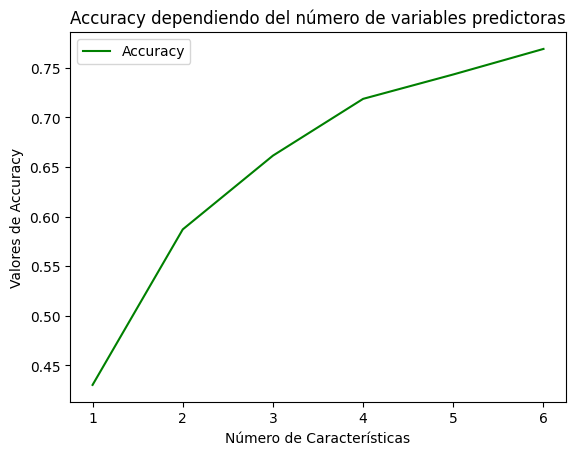

In [ ]:
#Graficar el número óptimo de características dependiendo de la medida utilizada
plt.plot(n_caracteristicas,acc_ncaracteristicas, color="green", label="Accuracy")
plt.title("Accuracy dependiendo del número de variables predictoras")
plt.xlabel("Número de Características")
plt.ylabel("Valores de Accuracy")
plt.legend()

In [ ]:
#Encontrar el número óptimo de variables predictoras
index_optimoF = np.argmax(acc_ncaracteristicas)
print("Número óptimo de variables mediante Filter:",n_caracteristicas[index_optimoF])

Número óptimo de variables mediante Filter: 6


#### **Wrapper**
---

In [ ]:
#Implementar el selector de características Wrapper con el conjunto de datos balanceado
kfolds = KFold(n_splits=3,shuffle=True)
n_caracteristicas = [1,2,3,4,5]
acc_ncaracteristicas = []

for n in n_caracteristicas:
  acc_n = []

  for tr_i, te_i in kfolds.split(xbal,ybal):
    #Definir los conjuntos de entrenamiento
    xtrain = xbal[tr_i,:]
    ytrain = ybal[tr_i]

    clf = RandomForestClassifier()

    #Filtrar el número de variables y ajustar los datos
    filter = SequentialFeatureSelector(clf, n_features_to_select=n)
    filter.fit(xtrain,ytrain)
    xtrain = filter.transform(xtrain)

    #Entrenar el modelo
    clf.fit(xtrain,ytrain)

    #Probar el modelo
    xtest = filter.transform(xbal[te_i,:])
    ytest = ybal[te_i]
    y_pred = clf.predict(xtest)

    #Calcular el accuracy del modelo con N variables
    accuracy_i = accuracy_score(ytest,y_pred)
    acc_n.append(accuracy_i)

  accuracy = np.average(acc_n)
  acc_ncaracteristicas.append(accuracy)

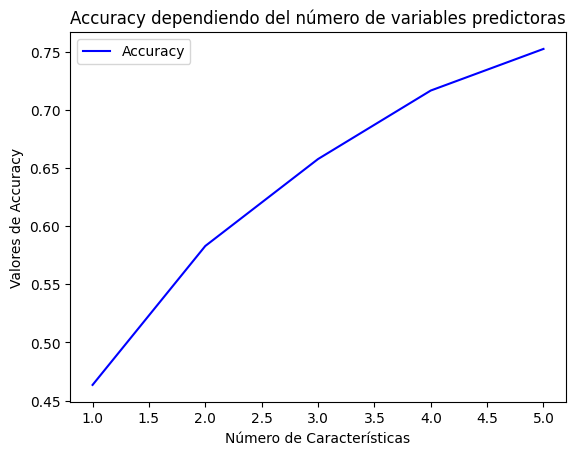

In [ ]:
#Graficar el número óptimo de características dependiendo de la medida utilizada
plt.plot(n_caracteristicas,acc_ncaracteristicas, color="blue", label="Accuracy")
plt.title("Accuracy dependiendo del número de variables predictoras")
plt.xlabel("Número de Características")
plt.ylabel("Valores de Accuracy")
plt.legend()

In [ ]:
#Encontrar el número óptimo de variables predictoras
index_optimoW = np.argmax(acc_ncaracteristicas)
print("Número óptimo de variables mediante Wrapper:",n_caracteristicas[index_optimoW])

Número óptimo de variables mediante Wrapper: 5


#### **Filter-Wrapper**
---

In [ ]:
#Implementar el selector de características Filter-Wrapper
kfolds = KFold(n_splits=3,shuffle=True)
n_caracteristicas = [1,2,3,4,5,6]
acc_ncaracteristicas = []

for n in n_caracteristicas:
  acc_n = []

  for tr_i, te_i in kfolds.split(xbal,ybal):
    #Definir los conjuntos de entrenamiento
    xtrain = xbal[tr_i,:]
    ytrain = ybal[tr_i]

    clf = RandomForestClassifier()

    #Filtrar el número de variables y ajustar los datos
    filter = RFE(clf,n_features_to_select=n)
    filter.fit(xtrain,ytrain)
    xtrain = filter.transform(xtrain)

    #Entrenar el modelo
    clf.fit(xtrain,ytrain)

    #Probar el modelo
    xtest = filter.transform(xbal[te_i,:])
    ytest = ybal[te_i]
    y_pred = clf.predict(xtest)

    #Calcular el accuracy del modelo con N variables
    accuracy_i = accuracy_score(ytest,y_pred)
    acc_n.append(accuracy_i)

  accuracy = np.average(acc_n)
  acc_ncaracteristicas.append(accuracy)

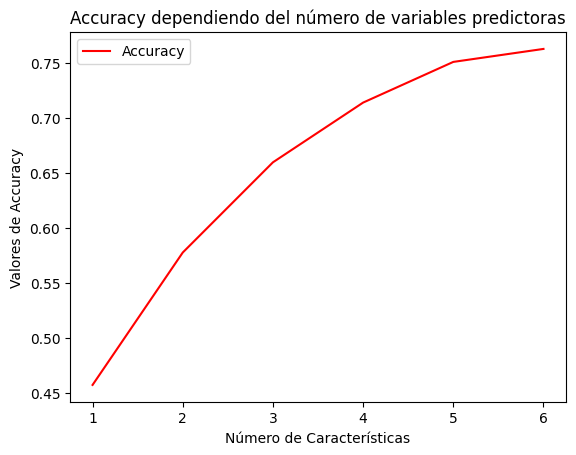

In [ ]:
#Graficar el número óptimo de características dependiendo de la medida utilizada
plt.plot(n_caracteristicas,acc_ncaracteristicas, color="red", label="Accuracy")
plt.title("Accuracy dependiendo del número de variables predictoras")
plt.xlabel("Número de Características")
plt.ylabel("Valores de Accuracy")
plt.legend()

In [ ]:
#Encontrar el número óptimo de variables predictoras
index_optimoFW = np.argmax(acc_ncaracteristicas)
print("Número óptimo de variables mediante Filter-Wrapper:",n_caracteristicas[index_optimoFW])

Número óptimo de variables mediante Filter-Wrapper: 6


Con esto se puede observar que las 6 variables son relevantes y lo mejore para encontrar el modelo óptimo es utilizar todas.

### **Regularización de los datos**
---

In [ ]:
#Estandarizar los datos para ver si el modelo es mejor
scaler = StandardScaler()
scaler.fit(xbal)

StandardScaler()

In [ ]:
#Estandarizar los datos
xbalstandard = scaler.fit_transform(xbal)

In [ ]:
#Analizar los resultados del RFC con hiperparámetros óptimos
hp_optimos = clf.best_params_
kfolds = KFold(n_splits=5, shuffle=True)
clfytest = []
clfypred = []
clf_i = RandomForestClassifier(**hp_optimos)

for train_i, test_i in kfolds.split(xbalstandard,ybal):
  #Preparar los datos de entrenamiento
  xtrain = xbalstandard[train_i,:]
  ytrain = ybal[train_i]

  #Preparar el modelo
  clf_i.fit(xtrain,ytrain)

  #Definir los conjuntos de prueba
  xtest = xbalstandard[test_i,:]
  ytest = ybal[test_i]

  #Evaluar los resultados
  ypred = clf_i.predict(xtest)
  clfytest.append(ytest)
  clfypred.append(ypred)

print(classification_report(np.concatenate(clfytest),np.concatenate(clfypred),zero_division=0))

              precision    recall  f1-score   support

           1       0.64      0.61      0.62      3726
           3       0.56      0.59      0.58      3726
           4       0.75      0.76      0.75      3726
           5       0.68      0.62      0.65      3726
           6       0.79      0.82      0.81      3726
           7       1.00      1.00      1.00      3726
           8       1.00      1.00      1.00      3726

    accuracy                           0.77     26082
   macro avg       0.77      0.77      0.77     26082
weighted avg       0.77      0.77      0.77     26082

